In [1]:
import os
import sys
import sklearn
import warnings
import numpy as np
import matplotlib as mpl
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.svm import LinearSVR
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.datasets import load_iris
from sklearn.datasets import make_moons
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from mpl_toolkits.mplot3d.proj3d import proj_transform
from matplotlib.patches import FancyArrowPatch

assert sklearn.__version__ >= "0.20"
assert sys.version_info >= (3, 5)

np.random.seed(42)
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
warnings.filterwarnings('ignore')

IMAGES_PATH = '.'
os.makedirs(IMAGES_PATH, exist_ok=True)
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=500):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [167]:
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)
    
    def do_3d_projection(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        return np.min(zs)


Saving figure unsupervised_3


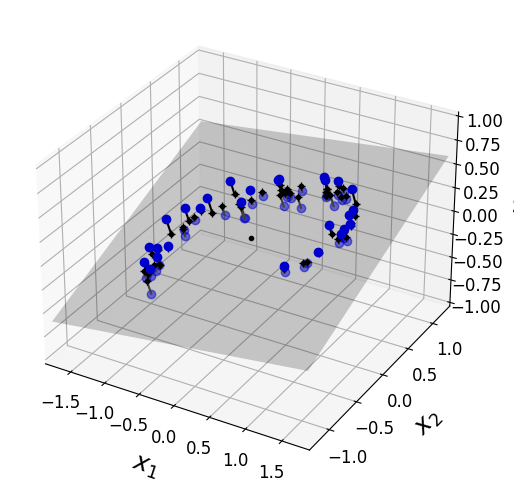

In [168]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

m, n = X.shape
S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

np.allclose(X_centered, U.dot(S).dot(Vt))

W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

X2D_using_svd = X2D

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

np.allclose(X2D, -X2D_using_svd)

X3D_inv = pca.inverse_transform(X2D)

np.allclose(X3D_inv, X)

X3D_inv_using_svd = X2D_using_svd.dot(Vt[:2, :])

np.allclose(X3D_inv_using_svd, X3D_inv - pca.mean_)

axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

# -----------
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

X3D_above = X[X[:, 2] > X3D_inv[:, 2]]
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)

ax.plot_surface(x1, x2, z, alpha=0.2, color="k")
np.linalg.norm(C, axis=0)
ax.plot([0], [0], [0], "k.")

for i in range(m):
    if X[i, 2] > X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-")
    else:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-", color="#505050")
    
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k+")
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k.")
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
ax.set_xlabel("$x_1$", fontsize=18, labelpad=10)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=10)
ax.set_zlabel("$x_3$", fontsize=18, labelpad=10)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])
plt.tight_layout()
save_fig('unsupervised_3')
plt.show()

Saving figure unsupervised_4


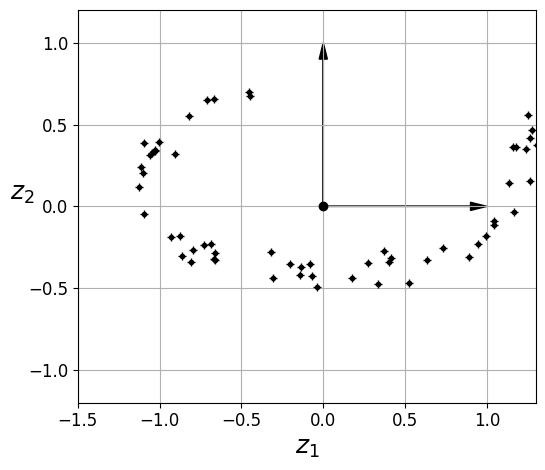

In [169]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
ax.plot(X2D[:, 0], X2D[:, 1], "k+")
ax.plot(X2D[:, 0], X2D[:, 1], "k.")
ax.plot([0], [0], "ko")
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([-1.5, 1.3, -1.2, 1.2])
ax.grid(True)
save_fig("unsupervised_4")
plt.show()

Saving figure unsupervised_5


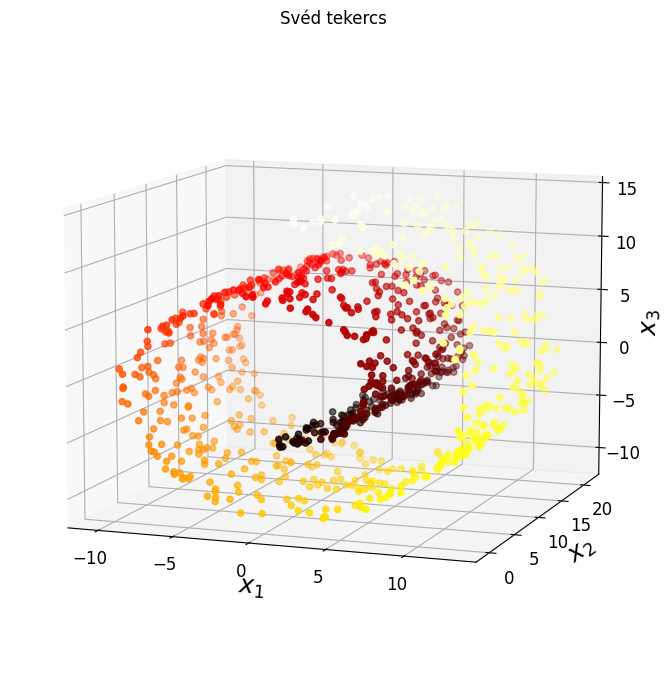

In [170]:
from sklearn.datasets import make_swiss_roll

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])
plt.title('Svéd tekercs')
save_fig("unsupervised_5")
plt.show()

Saving figure unsupervised_6


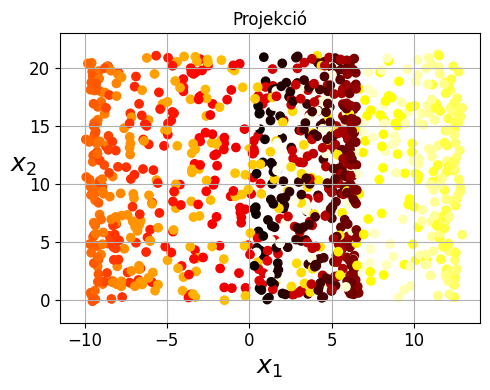

Saving figure unsupervised_7


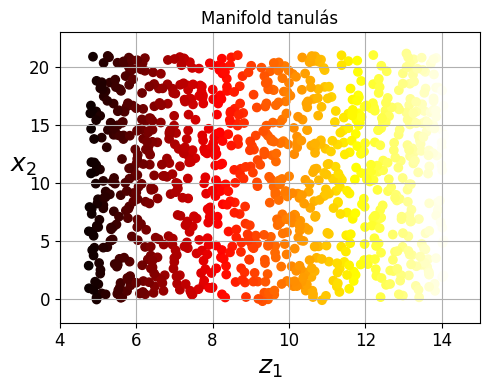

In [171]:
plt.figure(figsize=(5,4))
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)
plt.title('Projekció')
save_fig('unsupervised_6')
plt.show()

plt.figure(figsize=(5,4))
plt.scatter(t, X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)
plt.title('Manifold tanulás')
save_fig('unsupervised_7')
plt.show()

Saving figure unsupervised_8


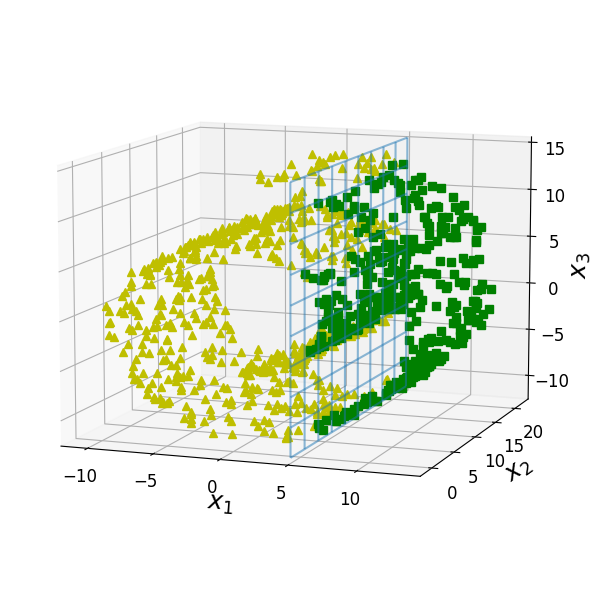

Saving figure unsupervised_9


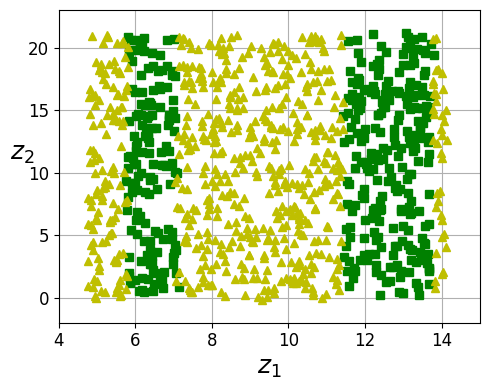

Saving figure unsupervised_10


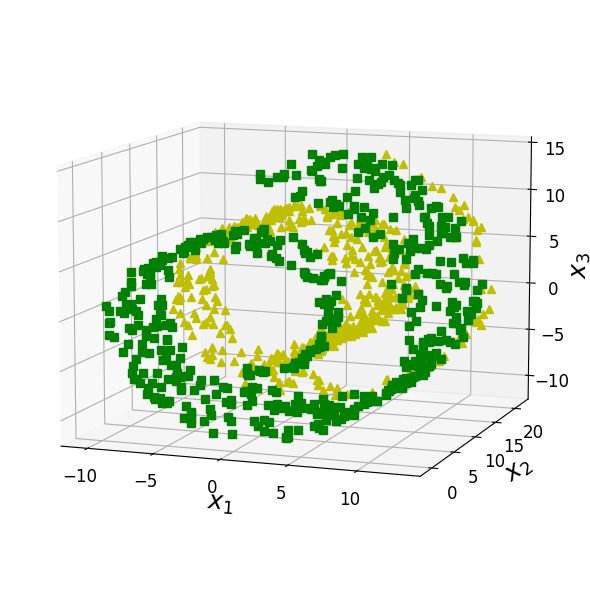

Saving figure unsupervised_11


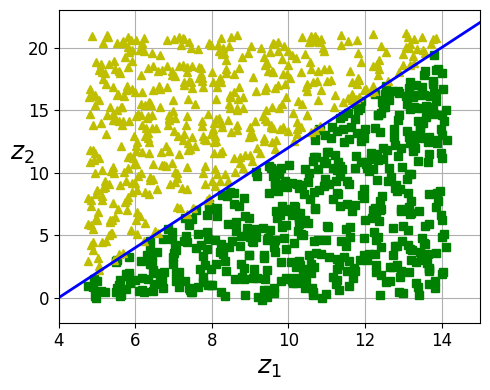

In [172]:
from matplotlib import gridspec

axes = [-11.5, 14, -2, 23, -12, 15]

x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(111, projection='3d')

positive_class = X[:, 0] > 5
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot_wireframe(5, x2, x3, alpha=0.5)
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("unsupervised_8")
plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

save_fig("unsupervised_9")
plt.show()

fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(111, projection='3d')

positive_class = 2 * (t[:] - 4) > X[:, 1]
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("unsupervised_10")
plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.plot([4, 15], [0, 22], "b-", linewidth=2)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

save_fig("unsupervised_11")
plt.show()

Saving figure unsupervised_12


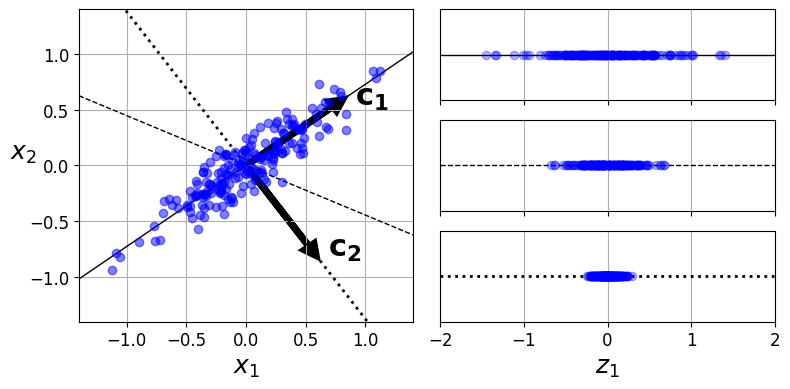

In [173]:
angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X = np.random.randn(m, 2) / 10
X = X.dot(np.array([[stretch, 0],[0, 1]])) # stretch
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]]) # rotate

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi/6), np.sin(angle - 2 * np.pi/6)])
u3 = np.array([np.cos(angle - np.pi/2), np.sin(angle - np.pi/2)])

X_proj1 = X.dot(u1.reshape(-1, 1))
X_proj2 = X.dot(u2.reshape(-1, 1))
X_proj3 = X.dot(u3.reshape(-1, 1))

plt.figure(figsize=(8,4))
plt.subplot2grid((3,2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4*u1[1]/u1[0], 1.4*u1[1]/u1[0]], "k-", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u2[1]/u2[0], 1.4*u2[1]/u2[0]], "k--", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u3[1]/u3[0], 1.4*u3[1]/u3[0]], "k:", linewidth=2)
plt.plot(X[:, 0], X[:, 1], "bo", alpha=0.5)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", fontsize=22)
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", fontsize=22)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot2grid((3,2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=1)
plt.plot(X_proj1[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=1)
plt.plot(X_proj2[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

save_fig("unsupervised_12")
plt.show()

Saving figure unsupervised_14


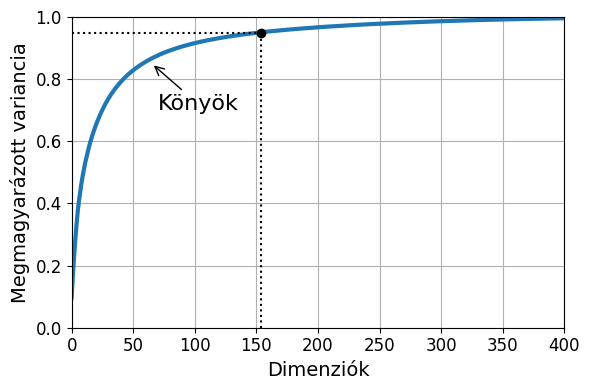

In [174]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimenziók")
plt.ylabel("Megmagyarázott variancia")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Könyök", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
save_fig("unsupervised_14")
plt.show()

Saving figure unsupervised_15


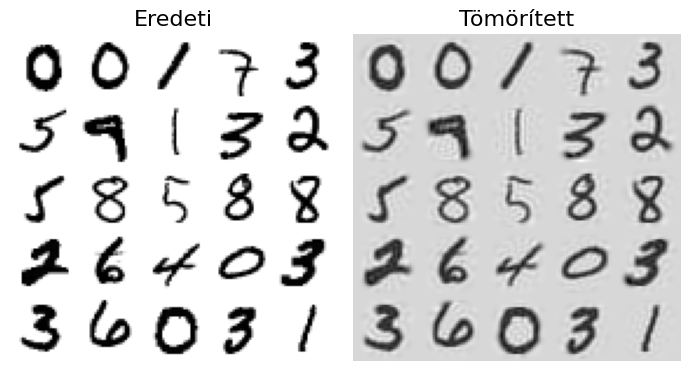

In [175]:
pca = PCA(n_components=154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

# EXTRA
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Eredeti", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Tömörített", fontsize=16)

save_fig("unsupervised_15")

Saving figure unsupervised_17


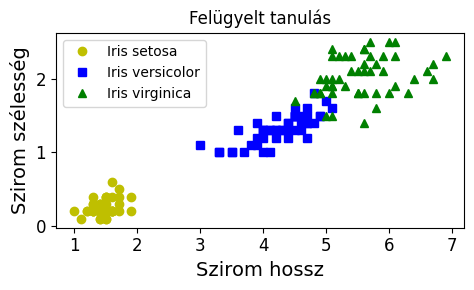

Saving figure unsupervised_18


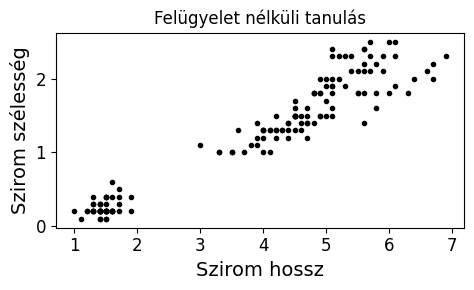

In [176]:
data = load_iris()
X = data.data
y = data.target
data.target_names

plt.figure(figsize=(5, 3))
plt.plot(X[y==0, 2], X[y==0, 3], "yo", label="Iris setosa")
plt.plot(X[y==1, 2], X[y==1, 3], "bs", label="Iris versicolor")
plt.plot(X[y==2, 2], X[y==2, 3], "g^", label="Iris virginica")
plt.xlabel("Szirom hossz")
plt.ylabel("Szirom szélesség")
plt.legend(fontsize=12)
plt.legend(fontsize=10)
plt.title('Felügyelt tanulás')
save_fig("unsupervised_17")
plt.show()

plt.figure(figsize=(5,3))
plt.scatter(X[:, 2], X[:, 3], c="k", marker=".")
plt.xlabel("Szirom hossz")
plt.ylabel("Szirom szélesség")
#plt.tick_params(labelleft=False)
plt.title('Felügyelet nélküli tanulás')
save_fig("unsupervised_18")
plt.show()

Saving figure unsupervised_19


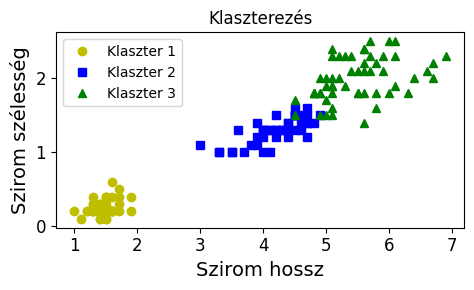

In [177]:
from sklearn.mixture import GaussianMixture
from scipy import stats

y_pred = GaussianMixture(n_components=3, random_state=42).fit(X).predict(X)

mapping = {}
for class_id in np.unique(y):
    mode, _ = stats.mode(y_pred[y==class_id])
    mapping[mode[0]] = class_id

y_pred = np.array([mapping[cluster_id] for cluster_id in y_pred])

plt.figure(figsize=(5,3))
plt.plot(X[y_pred==0, 2], X[y_pred==0, 3], "yo", label="Klaszter 1")
plt.plot(X[y_pred==1, 2], X[y_pred==1, 3], "bs", label="Klaszter 2")
plt.plot(X[y_pred==2, 2], X[y_pred==2, 3], "g^", label="Klaszter 3")
plt.xlabel("Szirom hossz")
plt.ylabel("Szirom szélesség")
plt.title('Klaszterezés')
plt.legend(loc="upper left", fontsize=10)
save_fig('unsupervised_19')
plt.show()

Saving figure unsupervised_20


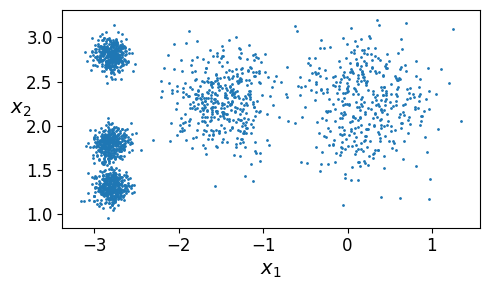

In [178]:
from sklearn.datasets import make_blobs

blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

plt.figure(figsize=(5, 3))
plot_clusters(X)
save_fig("unsupervised_20")
plt.show()

Saving figure unsupervised_21


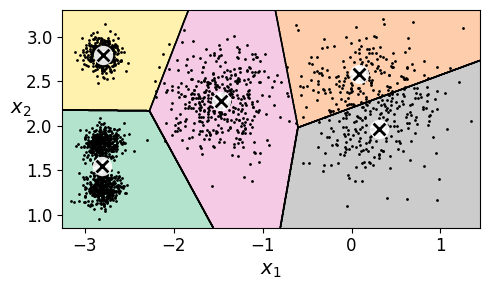

In [179]:
from sklearn.cluster import KMeans

k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)

def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$")
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)

plt.figure(figsize=(5, 3))
plot_decision_boundaries(kmeans, X)
save_fig("unsupervised_21")
plt.show()

Saving figure unsupervised_22


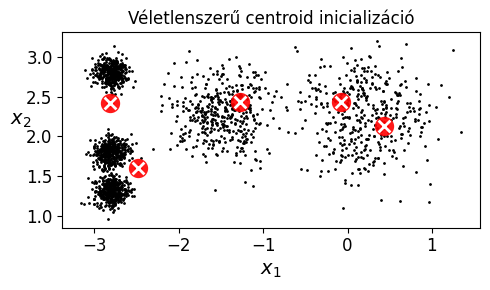

Saving figure unsupervised_23


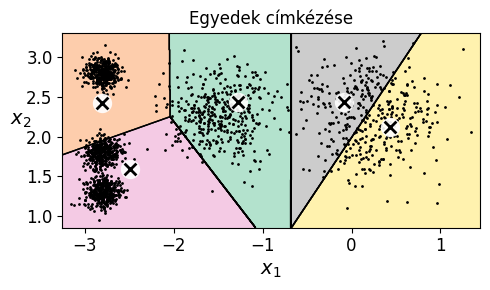

Saving figure unsupervised_24


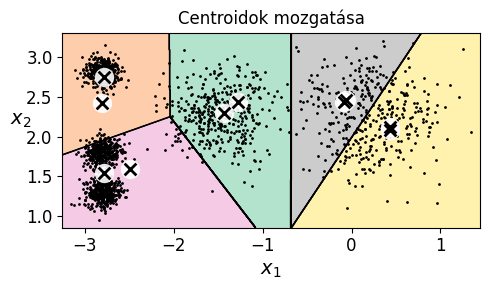

Saving figure unsupervised_25


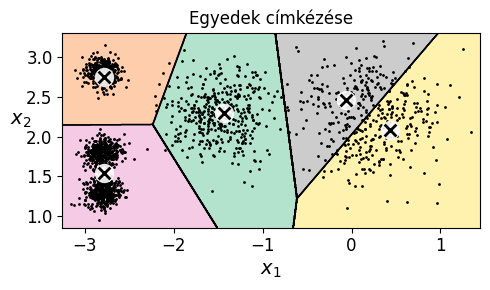

Saving figure unsupervised_26


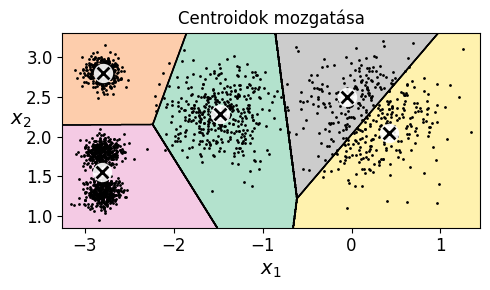

Saving figure unsupervised_27


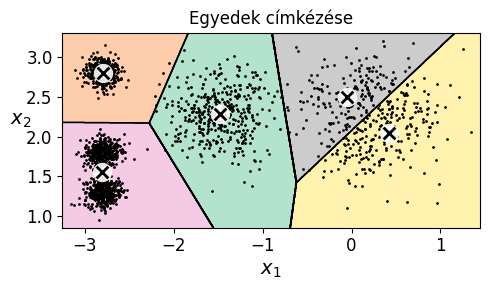

In [180]:
kmeans_iter1 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=1, random_state=0)
kmeans_iter2 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=2, random_state=0)
kmeans_iter3 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=3, random_state=0)
kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)


plt.figure(figsize=(5, 3))
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.xlabel("$x_1$", rotation=0)
plt.ylabel("$x_2$", rotation=0)
plt.title("Véletlenszerű centroid inicializáció")
save_fig('unsupervised_22')
plt.show()

plt.figure(figsize=(5, 3))
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=True, show_ylabels=True)
plt.xlabel("$x_1$", rotation=0)
plt.ylabel("$x_2$", rotation=0)
plt.title("Egyedek címkézése")
save_fig('unsupervised_23')
plt.show()

plt.figure(figsize=(5, 3))
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=True, show_ylabels=True)
plot_centroids(kmeans_iter2.cluster_centers_)
plt.xlabel("$x_1$", rotation=0)
plt.ylabel("$x_2$", rotation=0)
plt.title('Centroidok mozgatása')
save_fig('unsupervised_24')
plt.show()

plt.figure(figsize=(5, 3))
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=True, show_ylabels=True)
plt.xlabel("$x_1$", rotation=0)
plt.ylabel("$x_2$", rotation=0)
plt.title("Egyedek címkézése")
save_fig('unsupervised_25')
plt.show()

plt.figure(figsize=(5, 3))
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False, show_xlabels=True, show_ylabels=True)
plot_centroids(kmeans_iter3.cluster_centers_)
plt.xlabel("$x_1$", rotation=0)
plt.ylabel("$x_2$", rotation=0)
plt.title('Centroidok mozgatása')
save_fig('unsupervised_26')
plt.show()

plt.figure(figsize=(5, 3))
plot_decision_boundaries(kmeans_iter3, X, show_ylabels=True, show_xlabels=True)
plt.xlabel("$x_1$", rotation=0)
plt.ylabel("$x_2$", rotation=0)
plt.title("Egyedek címkézése")
save_fig('unsupervised_27')
plt.show()

Saving figure unsupervised_28


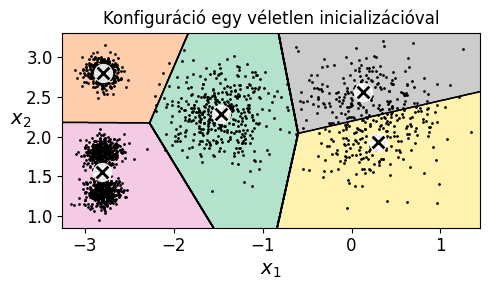

Saving figure unsupervised_29


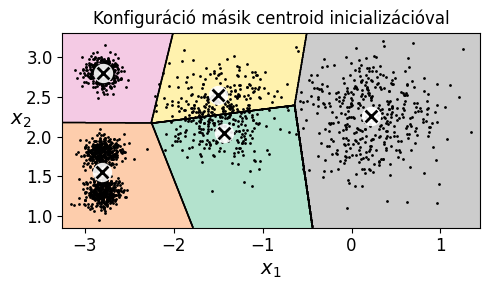

In [181]:
clusterer1 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="full", random_state=2)
clusterer2 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="full", random_state=5)

clusterer1.fit(X)
clusterer2.fit(X)

plt.figure(figsize=(5,3))
plot_decision_boundaries(clusterer1, X, show_ylabels=True, show_xlabels=True)
plt.title('Konfiguráció egy véletlen inicializációval')
save_fig('unsupervised_28')
plt.show()


plt.figure(figsize=(5,3))
plot_decision_boundaries(clusterer2, X, show_ylabels=True, show_xlabels=True)
plt.title('Konfiguráció másik centroid inicializációval')
save_fig('unsupervised_29')
plt.show()

Saving figure unsupervised_35


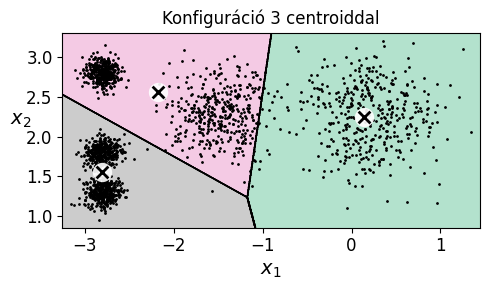

Saving figure unsupervised_36


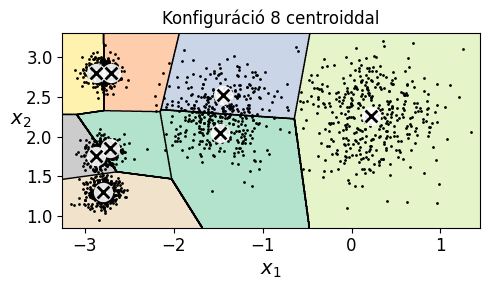

In [182]:
clusterer_k3 = KMeans(n_clusters=3, init="random", n_init=1,
                         algorithm="full", random_state=2)
clusterer_k8 = KMeans(n_clusters=8, init="random", n_init=1,
                         algorithm="full", random_state=5)

clusterer_k3.fit(X)
clusterer_k8.fit(X)

plt.figure(figsize=(5,3))
plot_decision_boundaries(clusterer_k3, X, show_ylabels=True, show_xlabels=True)
plt.title('Konfiguráció 3 centroiddal')
save_fig('unsupervised_35')
plt.show()


plt.figure(figsize=(5,3))
plot_decision_boundaries(clusterer_k8, X, show_ylabels=True, show_xlabels=True)
plt.title('Konfiguráció 8 centroiddal')
save_fig('unsupervised_36')
plt.show()

Saving figure unsupervised_30


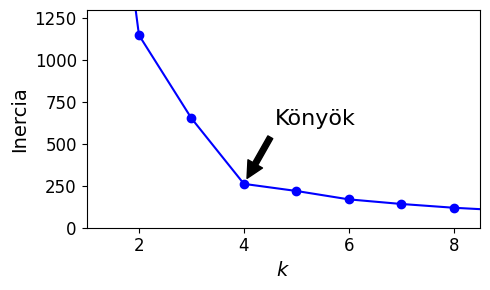

In [183]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(5, 3))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$")
plt.ylabel("Inercia")
plt.annotate('Könyök',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 1300])
save_fig("unsupervised_30")
plt.show()

Saving figure unsupervised_31


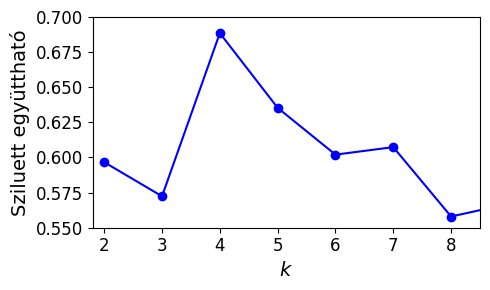

In [184]:
from sklearn.metrics import silhouette_score

silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

plt.figure(figsize=(5, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Sziluett együttható", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])
save_fig("unsupervised_31")
plt.show()

Saving figure unsupervised_32


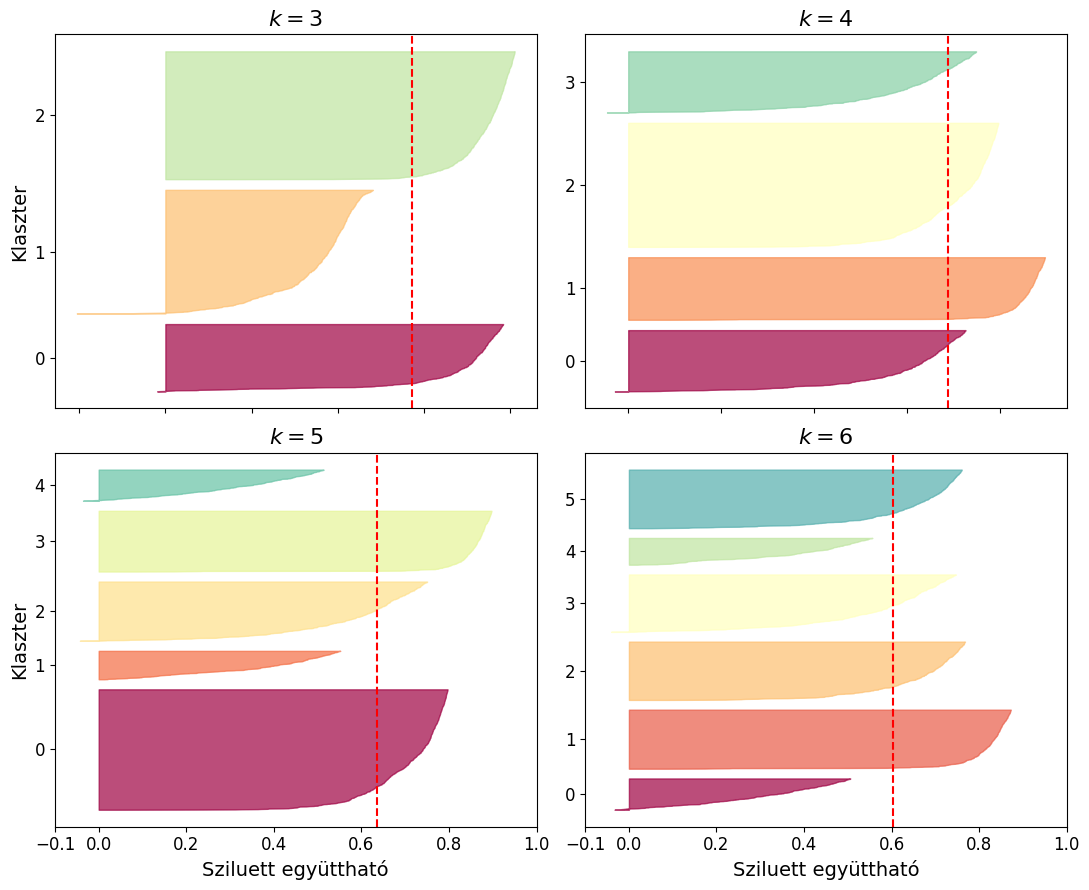

In [185]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Klaszter")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Sziluett együttható")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

save_fig("unsupervised_32")
plt.show()

Saving figure unsupervised_33


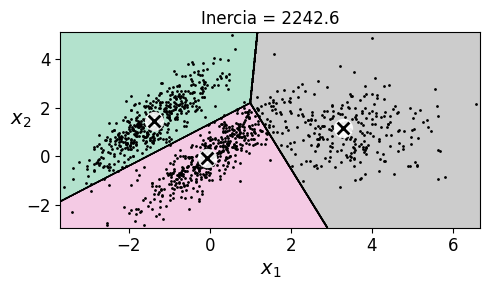

Saving figure unsupervised_34


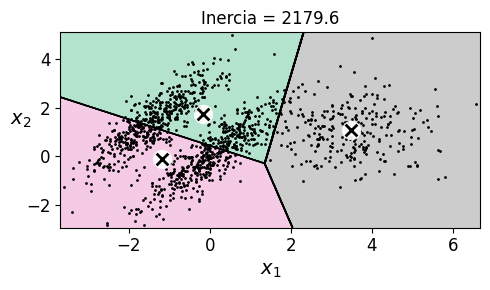

In [187]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

kmeans_good = KMeans(n_clusters=3, init=np.array([[-1.5, 2.5], [0.5, 0], [4, 0]]), n_init=1, random_state=42)
kmeans_bad = KMeans(n_clusters=3, random_state=42)
kmeans_good.fit(X)
kmeans_bad.fit(X)

plt.figure(figsize=(5, 3))
plot_decision_boundaries(kmeans_good, X)
plt.title("Inercia = {:.1f}".format(kmeans_good.inertia_))
save_fig('unsupervised_33')
plt.show()

plt.figure(figsize=(5, 3))
plot_decision_boundaries(kmeans_bad, X)
plt.title("Inercia = {:.1f}".format(kmeans_bad.inertia_))
save_fig('unsupervised_34')
plt.show()

Saving figure unsupervised_37


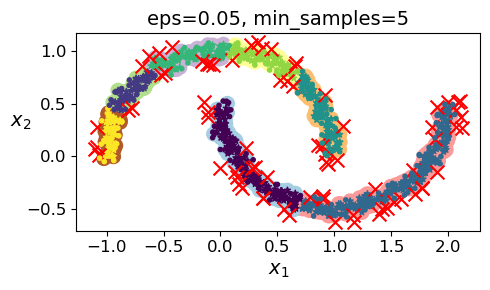

Saving figure unsupervised_38


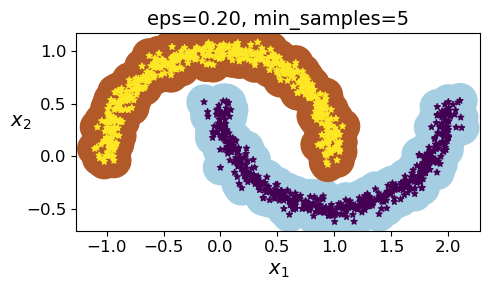

In [2]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X)


def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)


plt.figure(figsize=(5, 3))
plot_dbscan(dbscan, X, size=100)
save_fig('unsupervised_37')
plt.show()

plt.figure(figsize=(5, 3))
plot_dbscan(dbscan2, X, size=600)
save_fig('unsupervised_38')
plt.show()


In [6]:
def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$")
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)

def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

Saving figure unsupervised_39


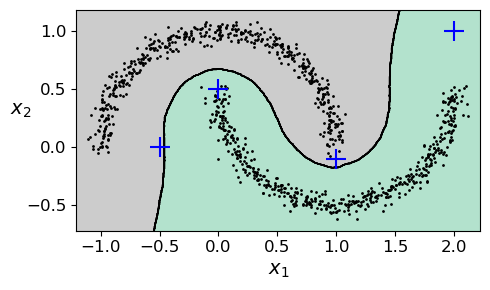

In [14]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan2.components_, dbscan2.labels_[dbscan2.core_sample_indices_])

X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
knn.predict(X_new)

knn.predict_proba(X_new)

plt.figure(figsize=(5, 3))
plot_decision_boundaries(knn, X, show_centroids=False)
plt.scatter(X_new[:, 0], X_new[:, 1], c="b", marker="+", s=200, zorder=10)
save_fig("unsupervised_39")
plt.show()

Saving figure unsupervised_40


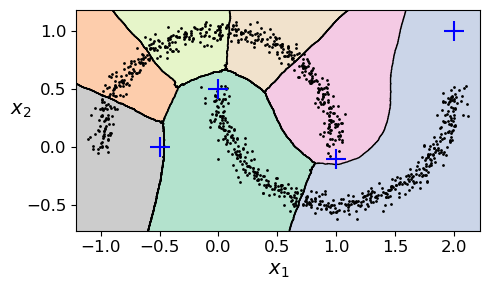

In [15]:
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
knn.predict(X_new)

knn.predict_proba(X_new)

plt.figure(figsize=(5, 3))
plot_decision_boundaries(knn, X, show_centroids=False)
plt.scatter(X_new[:, 0], X_new[:, 1], c="b", marker="+", s=200, zorder=10)
save_fig("unsupervised_40")
plt.show()